# NSQIP - K Nearest Neighbors
---


Here we'll try to fit a K Nearest Neighbors classifier. This dataset seems to have some significant non-linearities associated with it, and we have lots of cases, so it makes sense to try to fit points based on cases with similar data. 

Which points should be considered similar? This amounts to choosing a scaling factor to estimate how much weight to give to each potential predictor. We'll undertake a search to find the optimal scaling factor (and the number of neighbors K) using cross validation.

Our strategy is:
 - Divide the data into training and testing sets.
 - Choose hyper-parameters (including weights for each predictor) via cross validation.
 - Fit the model training set with the best hyper-parameters.
 - Check performance on the testing set.

Begin with imports of key libraries, and load the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as sklm
import random
import warnings 
import math
# warnings.filterwarnings("ignore") # Ignore annoying warnings

dataDir = './Data/'
mungedFileName = dataDir + 'mungedData.pkl'

cdf = pd.read_pickle(mungedFileName)

Next, determine which response and predictor columns we want to use.

In [2]:
# y is True if any readmission variable is hot. It's NaN if all variables are null.
yFull = cdf[['READMISSION1-Yes','READMISSION-Yes']].any(1)
yFull[cdf[['READMISSION1-Yes','READMISSION-Yes']].isnull().all(1)] = np.nan

# yFull = cdf['SUPINFEC-No Complication']


# Drop rows with NaN outcome y data
nanIdx = np.isnan(yFull).nonzero()
yFull = np.delete(yFull.ravel(), nanIdx ,axis=0).reshape(-1,1)
cdf.drop(cdf.index[nanIdx], axis=0, inplace=True)

# Add a BMI column
cdf.loc[:,'BMI'] = cdf.loc[:,'WEIGHT']*(1/2.20462)/(cdf.loc[:,'HEIGHT']*(1/39.3701)*\
                                                    cdf.loc[:,'HEIGHT']*(1/39.3701))

# List of predictors to keep
keepList1 = ['SEX', 'RACE_NEW','ETHNICITY_HISPANIC','AGE','ANESTHES','HEIGHT','WEIGHT','BMI',\
             'DIABETES','SMOKE','PACKS','ETOH','DYSPNEA','FNSTATUS2','VENTILAT',\
             'HXCOPD','CPNEUMON','HXCHF','HXMI','PRVPCI','PRVPCS','HXANGINA','HYPERMED',\
             'HXPVD','RENAFAIL','DIALYSIS','CVA','DISCANCR','WNDINF-','STEROID','WTLOSS',\
             'BLEEDDIS','PROPER30','ASACLASS','FNSTATUS1','RBC']
# An additional list of predictors that might be interesting
keepList2 = ['ASCITES','PRSODM','PRBUN','PRCREAT','PRALBUM','PRBILI','PRSGOT','PRALKPH',\
             'PRWBC','PRHCT','PRPLATE','PRPTT','PRINR','PRPT','PGY','ESOVAR','RESTPAIN',\
             'HXTIA','TRANSFUS','CHEMO','RADIO','PRSEPSIS','PREGNANCY','EMERGNCY',\
             'OPTIME','MALLAMP']

# Combine the lists
keepList = keepList1 + keepList2
# Make a list of any column in cdf whose name starts with a string in keepList
colsToKeep = [colName for colName in cdf.columns \
              if np.any([colName.startswith(keepItem) for keepItem in keepList])]
cdf = cdf[colsToKeep]

We will drop predictors that don't have any variance. (This can happen because we already dropped a bunch of cases for which our outcomes are not recorded.)

These regression models will fail on missing data, so we'll impute missing data for each column by setting it equal to the mean.

Since our regularization penalty is based on the size of the coefficients, we need to scale each column to have equal mean and variance. We don't need to add an intercept column; sklearn gives us an intercept as a fit option.

In [3]:
# Protect against only having one value in the columns.
# (Imputer will drop these columns, and then we won't know the names...)
for colName in cdf.columns:
    colData = cdf[colName]
    uniques = np.unique(colData)
    nonNanUniques = [item for item in uniques if ~np.isnan(item)]
    if len(nonNanUniques) < 2:
        print('Not enough variance, dropping column: %s' % colName)
        cdf.drop(colName, axis=1, inplace=True)

# Impute missing data in cdf
colNames = cdf.columns
imp = Imputer(missing_values='NaN', strategy='mean', axis=0, verbose=True)
imp.fit(cdf)
X = imp.transform(cdf)
X = pd.DataFrame(X, columns=colNames)

# We should scale columns here...
X = StandardScaler().fit_transform(X)
scaledX = pd.DataFrame(X, columns=colNames)

Not enough variance, dropping column: ANESTHES-Monitored Anesthesia Care
Not enough variance, dropping column: CPNEUMON-Yes
Not enough variance, dropping column: DIABETES-ORAL
Not enough variance, dropping column: FNSTATUS1-Independent
Not enough variance, dropping column: FNSTATUS1-Partially Dependent
Not enough variance, dropping column: FNSTATUS1-Totally Dependent
Not enough variance, dropping column: MALLAMP-1.0
Not enough variance, dropping column: MALLAMP-2.0
Not enough variance, dropping column: MALLAMP-3.0
Not enough variance, dropping column: MALLAMP-4.0
Not enough variance, dropping column: RBC


We break the data into separate fractions for training (2/3) and testing (1/3). All of our fitting and cross-validation will be done on the training set. The testing set will be held out to evaluate the final model performance.

In [4]:
# Split for validation
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaledX, yFull, test_size=0.33)
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

In [55]:
def scaledNeighbors(X, y, fractPerEval, scale):

    nSamp = len(y)
    nSampToUse = int(np.round(fractPerEval*nSamp))
    randOrder = np.random.permutation(nSamp)
    ixToUse = randOrder[0:nSampToUse]

    Xsamp = X[ixToUse,:]
    Ysamp = y[ixToUse]
    
    expScale = np.outer(np.ones([Xsamp.shape[0],1]),scale.reshape(1,-1))
    Xscaled = Xsamp*expScale
    knnc = KNeighborsClassifier(n_neighbors=20, weights='distance')
    score = cross_val_score(knnc, Xscaled, Ysamp, cv=2, scoring='roc_auc')
    return (1 - score.mean())

import scipy.optimize as opt
func = lambda args: scaledNeighbors(np.array(X_train), np.array(y_train), 0.3, args)

def printOut(X, y, scale):
    aScore = scaledNeighbors(X,y,1,scale)
    print('Score: %.3f' % (1-aScore))
    print(scale)
    return
printVec = lambda args: printOut(np.array(X_train), np.array(y_train), args)
res = opt.minimize(func, np.ones([X.shape[1],1]), method='BFGS',callback=printVec,\
              options={'maxiter': 10, 'disp': True, 'eps':0.5})

Score: 0.656
[ 0.70593461  0.96490395  0.9131209   0.78270407  1.06821565  0.9342324
  1.12963513  0.99586724  0.78517355  1.01901055  0.84403914  0.90752837
  0.7248923   0.88202918  0.95051964  1.07697877  0.99694638  0.93679371
  0.71697789  0.76831358  0.86742968  1.00420126  0.94793346  0.99483474
  0.91551468  0.86467099  0.90170678  0.96285518  0.86818822  0.9614515
  1.18067461  0.86066564  0.89027887  0.82526276  0.95215493  1.0910396
  0.88723371  0.84946388  0.71064974  1.10489796  1.1592028   1.04073204
  1.06034411  0.8912064   0.94908561  1.08675342  0.71277728  1.11596708
  0.94883338  1.03684821  0.93696571  1.01830652  0.9833305   0.89756956
  0.81153073  0.87582268  0.99137866  0.92634195  0.96242322  0.88483467
  0.98993456  0.97190939  0.97549718  0.82430437  0.77483926  0.91074698
  0.94613641  0.99910769  1.04965073  0.66790463  0.8067865   0.94041845
  0.80381772  0.98243495  0.922969    0.9067739   0.97795689  1.09461058
  0.99353622  0.99572593  0.91509871  0.9

In [39]:
np.array(X_train)

array([[ 0.06959397, -0.03368861,  0.39770736, ...,  2.15461631,
         0.06648782,  1.93629453],
       [ 0.992906  , -0.03368861,  0.39770736, ..., -0.49906775,
         0.06648782, -0.4561043 ],
       [ 0.93519899, -0.03368861,  0.39770736, ..., -0.43782889,
         0.06648782, -0.50477746],
       ..., 
       [ 1.51226901, -0.03368861,  0.39770736, ...,  0.03166906,
         0.06648782, -0.57759154],
       [-0.56518305, -0.03368861,  0.39770736, ..., -0.45824184,
         0.06648782, -0.94549082],
       [-1.71932309, -0.03368861,  0.39770736, ...,  0.70529656,
         0.06648782,  0.05735419]])

In [7]:
knnc = KNeighborsClassifier()
tunedParam = 'n_neighbors'
tuned_parameters = [{tunedParam: [10,20,50,100],\
                     'weights': ['uniform','distance']}]
gscv = GridSearchCV(knnc,tuned_parameters,cv=10,scoring='roc_auc',verbose=1)
gscv.fit(X_train, y_train)

Fitting 10 folds for each of 8 candidates, totalling 80 fits


[Parallel(n_jobs=1)]: Done  49 tasks       | elapsed:  1.3min
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed:  2.1min finished


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='distance'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'weights': ['uniform', 'distance'], 'n_neighbors': [10, 20, 50, 100]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=1)

Best Params: 
{'weights': 'distance', 'n_neighbors': 100}


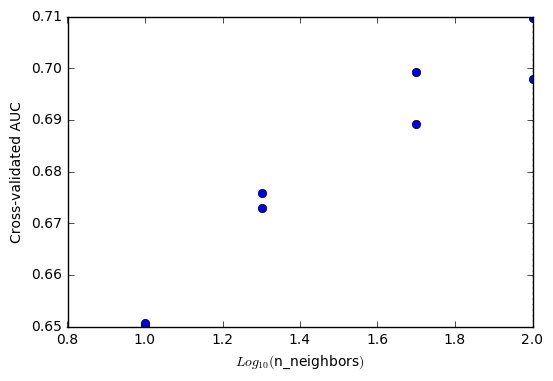

In [8]:
gscv.grid_scores_
print('Best Params: ')
print(gscv.best_params_)
means = [mean_score for params, mean_score, scores in gscv.grid_scores_]
Cs = [params[tunedParam] for params, mean_score, scores in gscv.grid_scores_]
plt.plot(np.log10(Cs), means,'bo')
bestC = gscv.best_params_[tunedParam]
ylims = plt.gca().get_ylim()
plt.plot(np.log10([bestC, bestC]),ylims,color='k',ls=':')
plt.ylim(ylims)
plt.xlabel('$Log_{10}($' + tunedParam + '$)$')
plt.ylabel('Cross-validated AUC')
plt.show()

Plot ROC curves for in-sample training data, and test data, for both the full and reduced model. The test data here was not used to fit the model at all, so it should approximate how our model will perform prospectively on new data. Furthermore, if we've done a good job regularizing, the in-sample performance should be pretty close to the test data performance.

In-sample ROC AUC = 1.000 
Test ROC AUC = 0.687 


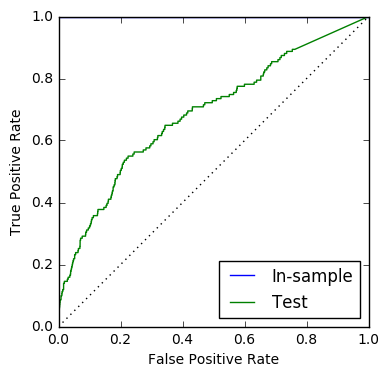

In [9]:
# Plot an ROC curve for training
plt.clf
pred_train = gscv.predict_proba(X_train)[:,1]
rocAUC_train = sklm.roc_auc_score(y_train,pred_train)
print('In-sample ROC AUC = %.3f ' % rocAUC_train)
fpr, tpr, _ = sklm.roc_curve(y_train, pred_train)
plt.figure()
plt.plot(fpr,tpr,label='In-sample')

# Plot an ROC curve for test data
pred_test = gscv.predict_proba(X_test)[:,1]
rocAUC_test = sklm.roc_auc_score(y_test,pred_test)
print('Test ROC AUC = %.3f ' % rocAUC_test)
fpr, tpr, _ = sklm.roc_curve(y_test, pred_test)
plt.plot(fpr,tpr,label='Test')

# Format the ROC plot
plt.plot([0, 1], [0, 1], color='k', linestyle=':')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right')
plt.show()